# Library

In [6]:
# Library
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
# from tensorflow import set_random_seed
from numpy.random import seed

In [7]:
%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode()

In [9]:
tf.random.set_seed(1)
seed(1)

In [39]:
from sklearn import metrics

def scoring(y_true, y_pred):
    r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
    
    corr = round(np.corrcoef(y_true, y_pred)[0, 1], 3)
    mape = round(metrics.mean_absolute_percentage_error(y_true, y_pred) * 100, 3)
    rmse = round(metrics.mean_squared_error(y_true, y_pred, squared=False), 3)
    
    df = pd.DataFrame({
        "R2": r2,
        "Corr": corr,
        'RMSE': rmse,
        "MAPE": mape
    }, index=[0])
    
    return df

# Data

In [10]:
df_train = pd.read_csv("train.csv", parse_dates=["date"])
df_test = pd.read_csv("test.csv", parse_dates=["date"])

In [11]:
df_train

date  store  item  sales
0      2013-01-01      1     1     13
1      2013-01-02      1     1     11
2      2013-01-03      1     1     14
3      2013-01-04      1     1     13
4      2013-01-05      1     1     10
...           ...    ...   ...    ...
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82

[913000 rows x 4 columns]

In [12]:
df_test

id       date  store  item
0          0 2018-01-01      1     1
1          1 2018-01-02      1     1
2          2 2018-01-03      1     1
3          3 2018-01-04      1     1
4          4 2018-01-05      1     1
...      ...        ...    ...   ...
44995  44995 2018-03-27     10    50
44996  44996 2018-03-28     10    50
44997  44997 2018-03-29     10    50
44998  44998 2018-03-30     10    50
44999  44999 2018-03-31     10    50

[45000 rows x 4 columns]

In [14]:
print("Min date from train set: %s" % df_train["date"].min().date())
print("Max date from train set: %s" % df_train["date"].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


In [15]:
lag_size = (df_test["date"].max().date() - df_train["date"].max().date()).days
print("Min date from test set: %s" % df_test["date"].min().date())
print("Max date from test set: %s" % df_test["date"].max().date())
print("Forecast lag size", lag_size)

Min date from test set: 2018-01-01
Max date from test set: 2018-03-31
Forecast lag size 90


# EDA

In [16]:
# 일별 합, 일별 Store별 합, 일별 Item별 합
df_train_daily_sales = df_train.groupby("date", as_index=False)["sales"].sum()
df_train_store_daily_sales = df_train.groupby(["store", "date"], as_index=False)["sales"].sum()
df_train_item_daily_sales = df_train.groupby(["item", "date"], as_index=False)["sales"].sum()

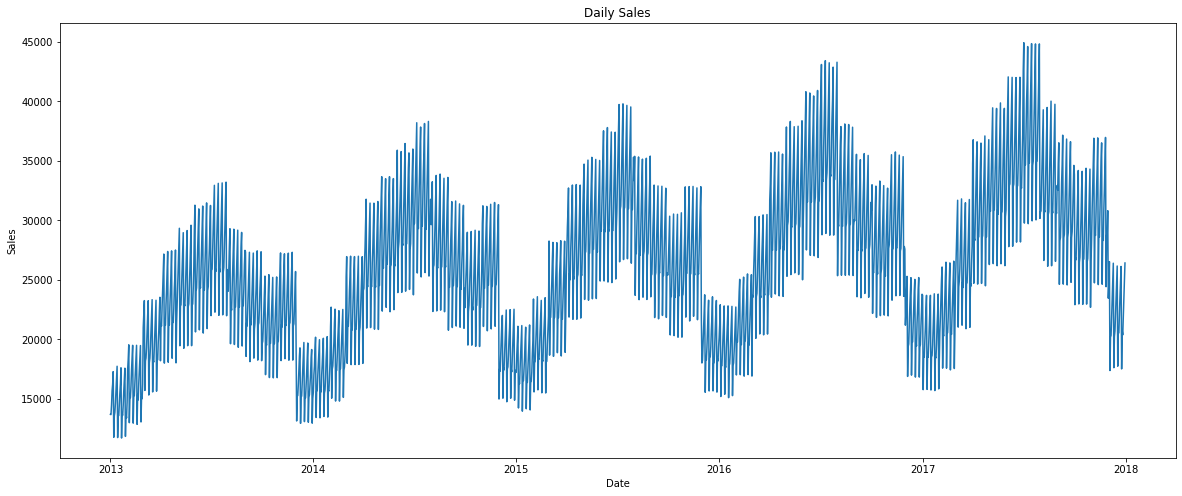

In [17]:
# 일별 총 판매량
plt.figure(figsize=(20,8))
plt.plot(df_train_daily_sales["date"], df_train_daily_sales["sales"])
plt.title("Daily Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

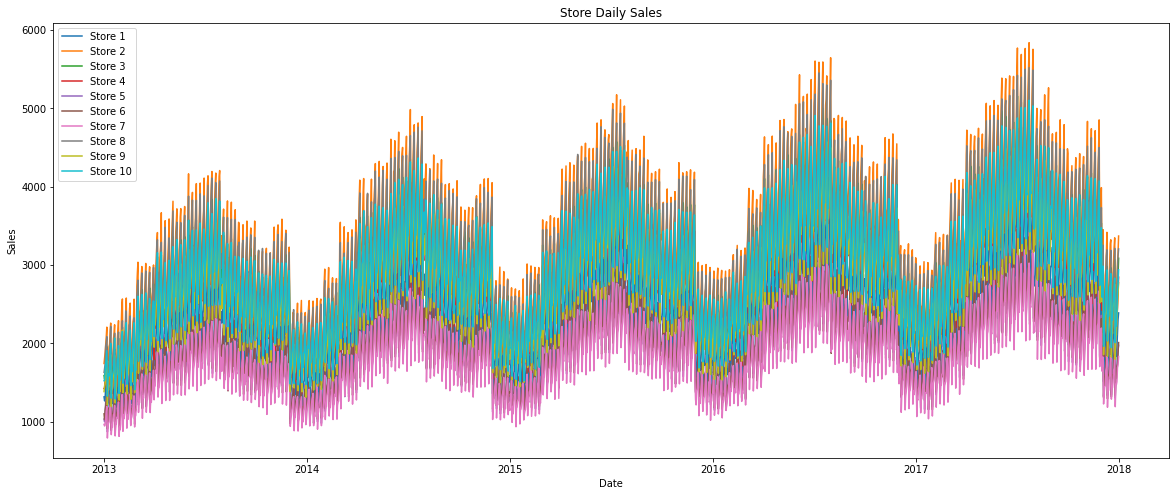

In [18]:
# 일별 Store별 총 판매량
plt.figure(figsize=(20,8))

for i in range(1, 11):
    temp = df_train_store_daily_sales[df_train_store_daily_sales.store==i]
    plt.plot(temp["date"], temp["sales"], label="Store %d" % i)
    
plt.legend()
plt.title("Store Daily Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

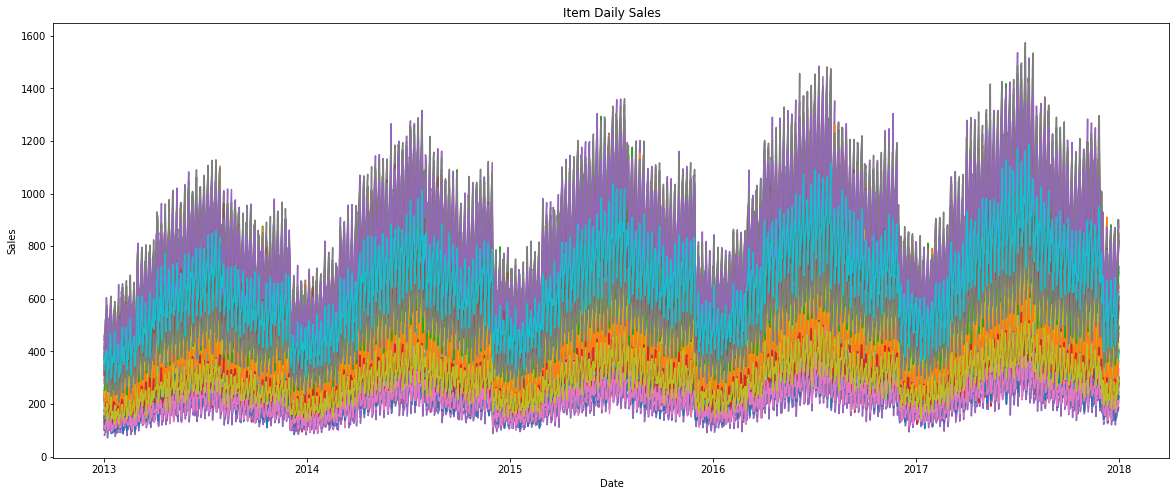

In [20]:
# 일별, Item별 총 판매량
plt.figure(figsize=(20,8))

for i in range(1, 51):
    temp = df_train_item_daily_sales[df_train_item_daily_sales.item==i]
    plt.plot(temp["date"], temp["sales"], label="Item %d" % i)
    
plt.title("Item Daily Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Preprocessing

In [21]:
# 2017년 데이터만 필터링
df_train_filter = df_train[df_train["date"] >= "2017-01-01"]

In [24]:
# Time Series에 맞께 변형
# 30일치로 90일 뒤를 핛습
# Test Seet이 90일치
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
        
    # Current timestamp
    cols.append(data)
    names += [('%s(t)' % col) for col in data.columns]
    
    # Target Timestamp
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [25]:
train_gp = df_train_filter.sort_values("date").groupby(["item", "store", "date"], as_index=False)
train_gp = train_gp.agg({'sales':["mean"]})
train_gp.columns = ["item", "store", "date", "sales"]

window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop("date", axis=1), 
                              window=window, lag=lag)

last_item = "item(t-%d)" % window
last_store = "store(t-%d)" % window
series = series[(series["store(t)"] == series[last_store])]
series = series[(series["item(t)"] == series[last_item])]

columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ["item", "store"]]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ["item", "store"]]
    
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(["item(t)", "store(t)"], axis=1, inplace=True)

In [26]:
series

sales(t-29)  sales(t-28)  sales(t-27)  sales(t-26)  sales(t-25)  \
29             19.0         15.0         10.0         16.0         14.0   
30             15.0         10.0         16.0         14.0         24.0   
31             10.0         16.0         14.0         24.0         14.0   
32             16.0         14.0         24.0         14.0         20.0   
33             14.0         24.0         14.0         20.0         18.0   
...             ...          ...          ...          ...          ...   
182405         79.0         89.0         96.0         92.0        102.0   
182406         89.0         96.0         92.0        102.0         60.0   
182407         96.0         92.0        102.0         60.0         81.0   
182408         92.0        102.0         60.0         81.0         79.0   
182409        102.0         60.0         81.0         79.0         78.0   

        sales(t-24)  sales(t-23)  sales(t-22)  sales(t-21)  sales(t-20)  ...  \
29             24.0         14.0         20.0         18.0         11.0  ...   
30             14.0         20.0         18.0         11.0         14.0  ...   
31             20.0         18.0         11.0         14.0         17.0  ...   
32             18.0         11.0         14.0         17.0          7.0  ...   
33             11.0         14.0         17.0          7.0         16.0  ...   
...             ...          ...          ...          ...          ...  ...   
182405         60.0         81.0         79.0         78.0         97.0  ...   
182406         81.0         79.0         78.0         97.0         93.0  ...   
182407         79.0         78.0         97.0         93.0         96.0  ...   
182408         78.0         97.0         93.0         96.0         74.0  ...   
182409         97.0         93.0         96.0         74.0         70.0  ...   

        sales(t-8)  sales(t-7)  sales(t-6)  sales(t-5)  sales(t-4)  \
29            21.0         9.0        18.0        14.0        13.0   
30             9.0        18.0        14.0        13.0        10.0   
31            18.0        14.0        13.0        10.0        16.0   
32            14.0        13.0        10.0        16.0        24.0   
33            13.0        10.0        16.0        24.0         9.0   
...            ...         ...         ...         ...         ...   
182405        72.0        89.0        97.0        97.0        99.0   
182406        89.0        97.0        97.0        99.0        63.0   
182407        97.0        97.0        99.0        63.0        79.0   
182408        97.0        99.0        63.0        79.0        80.0   
182409        99.0        63.0        79.0        80.0        82.0   

        sales(t-3)  sales(t-2)  sales(t-1)  sales(t)  sales(t+90)  
29            10.0        16.0        24.0         9         33.0  
30            16.0        24.0         9.0        17         15.0  
31            24.0         9.0        17.0        15         21.0  
32             9.0        17.0        15.0        17         29.0  
33            17.0        15.0        17.0        24         19.0  
...            ...         ...         ...       ...          ...  
182405        63.0        79.0        80.0        82         63.0  
182406        79.0        80.0        82.0        90         59.0  
182407        80.0        82.0        90.0       103         74.0  
182408        82.0        90.0       103.0        99         62.0  
182409        90.0       103.0        99.0        71         82.0  

[167910 rows x 31 columns]

# Train/Test Split

In [27]:
# Label
labels_col = 'sales(t+%d)' % lag_size   # sales(t+90)
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_test, y_train, y_test = train_test_split(series, labels.values,
                                                   test_size=0.4, 
                                                   random_state=0)


In [29]:
print('Train set shape : ', X_train.shape)
print("Test set shape : ", X_test.shape)

Train set shape :  (100746, 30)
Test set shape :  (67164, 30)


# MLP

In [30]:
# 40번 반복학습, 한 번에 256개씩 학습, learning rate는 0.0003으로 설정
# optimizer는 adam을 사용
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [31]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation="relu",
                   input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss="mse", optimizer=adam)

2021-10-24 21:59:38.216507: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               3100      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Prediction
mlp_history = model_mlp.fit(X_train.values, y_train,
                           validation_data=(X_test.values, y_test),
                           epochs=epochs, verbose=2)

2021-10-24 22:04:13.422553: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
3149/3149 - 3s - loss: 396.4821 - val_loss: 370.4280
Epoch 2/40
3149/3149 - 2s - loss: 363.6129 - val_loss: 364.3400
Epoch 3/40
3149/3149 - 2s - loss: 357.9035 - val_loss: 373.9396
Epoch 4/40
3149/3149 - 2s - loss: 356.3820 - val_loss: 382.0649
Epoch 5/40
3149/3149 - 2s - loss: 355.1825 - val_loss: 355.7310
Epoch 6/40
3149/3149 - 2s - loss: 353.8272 - val_loss: 352.4772
Epoch 7/40
3149/3149 - 2s - loss: 352.5408 - val_loss: 356.9906
Epoch 8/40
3149/3149 - 2s - loss: 351.6213 - val_loss: 349.7079
Epoch 9/40
3149/3149 - 2s - loss: 351.0474 - val_loss: 355.4981
Epoch 10/40
3149/3149 - 2s - loss: 349.5807 - val_loss: 350.8213
Epoch 11/40
3149/3149 - 2s - loss: 348.9591 - val_loss: 347.4316
Epoch 12/40
3149/3149 - 2s - loss: 347.3357 - val_loss: 346.9953
Epoch 13/40
3149/3149 - 2s - loss: 348.3905 - val_loss: 348.3451
Epoch 14/40
3149/3149 - 2s - loss: 346.7983 - val_loss: 347.1575
Epoch 15/40
3149/3149 - 2s - loss: 345.8221 - val_loss: 344.8350
Epoch 16/40
3149/3149 - 2s - loss:

In [35]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_test.values)

Y_train_ = pd.DataFrame({'y_true': y_train, 
                         'y_pred': mlp_train_pred.reshape(mlp_train_pred.shape[0],)}).set_index(X_train.index).sort_index()
Y_train_ = pd.merge(Y_train_, train_gp,
                   left_index=True, right_index=True,
                   how="left")

Y_valid_ = pd.DataFrame({'y_true': y_test, 
                         'y_pred': mlp_valid_pred.reshape(mlp_valid_pred.shape[0],)}).set_index(X_test.index).sort_index()
Y_valid_ = pd.merge(Y_valid_, train_gp,
                   left_index=True, right_index=True,
                   how="left")

In [40]:
# Train 성능
scoring(Y_train_.y_true, Y_train_.y_pred)

R2   Corr    RMSE    MAPE
0  66.482  0.816  18.309  30.293

In [41]:
# Validation 성능
scoring(Y_valid_.y_true, Y_valid_.y_pred)

R2   Corr    RMSE    MAPE
0  65.791  0.811  18.438  30.437